In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

In [6]:
data_path = Path("./data/data/calib/calib_2015/1600mm/pls/")

In [9]:
from lib.data_handling import load_data

sample_data = load_data(data_path, 1, True)


Loading data: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

from lib.data_handling import WavelengthMaskTransformer
from lib.reproduction import masks, spectral_ranges

def plot_spectra(
    data: pd.DataFrame,
    max_gap_threshold=10,
):
    sns.set_style("white")  # Set the Seaborn style

    # Transform the data using WavelengthMaskTransformer
    wmt = WavelengthMaskTransformer(masks)
    transformed = wmt.fit_transform(data)

    df = pd.DataFrame({"wave": transformed["wave"], "shot_avg": transformed["shot_avg"]})

    # Debug: Print the DataFrame structure
    print("DataFrame columns:", df.columns)

    # Check if 'wave' and 'shot_avg' are in the DataFrame
    if "wave" not in df.columns or "shot_avg" not in df.columns:
        raise ValueError("Expected columns 'wave' and 'shot_avg' not found in the DataFrame.")

    # Extract wavelength and intensity data
    wave, intensity = df["wave"], df["shot_avg"]

    plt.figure(figsize=(10, 6))

    # Plot segments with gaps smaller than max_gap_threshold
    start_idx = 0
    for i in range(1, len(wave)):
        if wave.iloc[i] - wave.iloc[i - 1] > float(max_gap_threshold):
            sns.lineplot(x=wave.iloc[start_idx:i], y=intensity.iloc[start_idx:i], color="blue")
            start_idx = i
    sns.lineplot(x=wave.iloc[start_idx:], y=intensity.iloc[start_idx:], color="blue")  # plot the last segment

    # Colors for the spectral ranges
    spectral_colors = {
        "UV": "#BA55D3",  # Medium Orchid
        "VIO": "#00FF00",  # Bright Green
        "VNIR": "#8B0000",  # Deep Red
    }

    # Overlaying spectral ranges
    for range_name, (start, end) in spectral_ranges.items():
        plt.axvspan(start, end, alpha=0.3, color=spectral_colors[range_name], label=range_name)

    for i, (start, end) in enumerate(masks):
        plt.axvspan(start, end, alpha=0.25, color="#0099ff", label="Mask" if i == 0 else None)

    # Labeling and title
    plt.title("Spectral Analysis of Sample")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")

    plt.legend(title="Spectral Ranges")
    plt.show()

In [12]:
sample = sample_data["jsc1399"]

DataFrame columns: Index(['wave', 'shot_avg'], dtype='object')


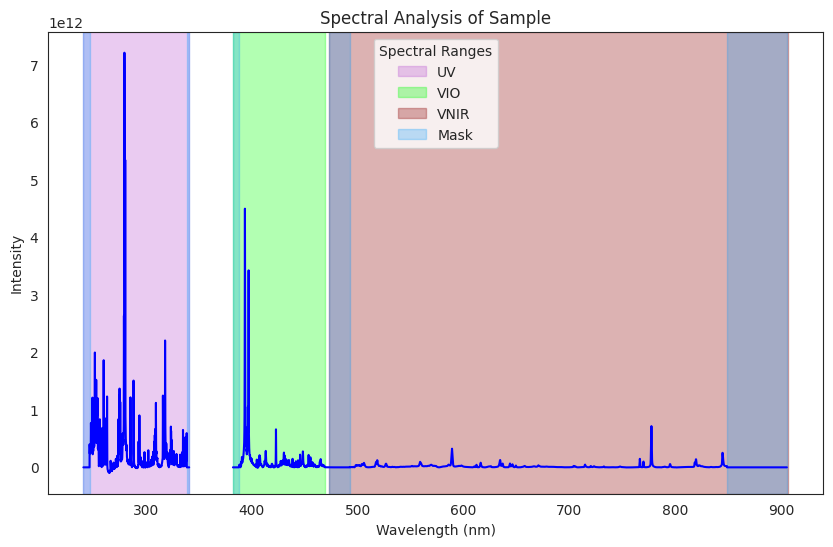

In [13]:
first_location = sample["2013_09_11_151245_ccs"]

plot_spectra(first_location)

In [16]:
# make average of each location. Sample is a dict of locations each with a value as a dataframe
remaining_locations = sample.keys() - {"2013_09_11_151245_ccs"}

mean_df = first_location.copy()

for location in remaining_locations:
    mean_df["shot_avg"] += sample[location]["shot_avg"]
    
mean_df["shot_avg"] /= len(sample.keys())

DataFrame columns: Index(['wave', 'shot_avg'], dtype='object')


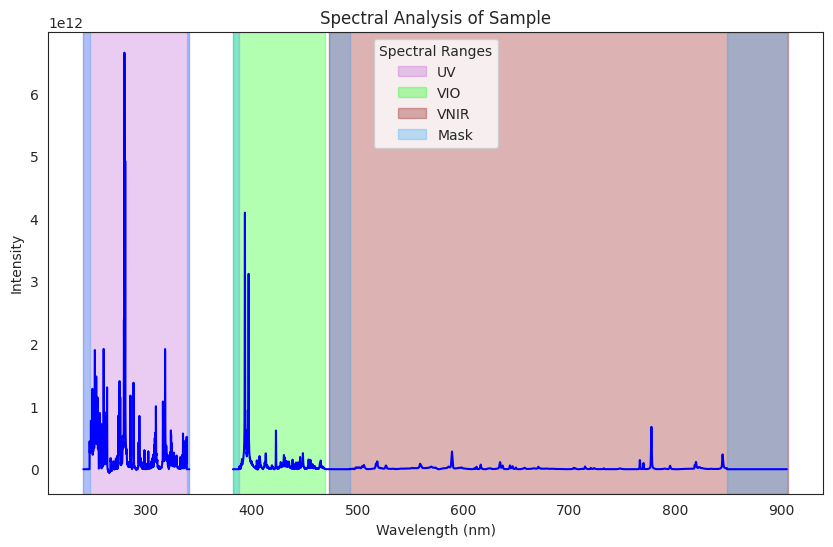

In [18]:
plot_spectra(mean_df)

In [45]:
# Colors for the spectral ranges
spectral_colors = {
    "UV": "#BA55D3",  # Medium Orchid
    "VIO": "#00FF00",  # Bright Green
    "VNIR": "#8B0000",  # Deep Red
}


def plot_spectra_double(
    data: pd.DataFrame,
    data2: pd.DataFrame,  # New parameter for the additional DataFrame
    max_gap_threshold=10,
):
    sns.set_style("white")  # Set the Seaborn style

    # Apply transformation to both dataframes
    wmt = WavelengthMaskTransformer(masks)
    transformed = wmt.fit_transform(data)
    transformed2 = wmt.transform(data2)  # Use .transform() for the second DataFrame if it fits without refitting

    df = pd.DataFrame({"wave": transformed["wave"], "shot_avg": transformed["shot_avg"]})
    df2 = pd.DataFrame({"wave": transformed2["wave"], "shot_avg": transformed2["shot_avg"]})

    # Check if 'wave' and 'shot_avg' are in both DataFrames
    for dataframe in [df, df2]:
        if "wave" not in dataframe.columns or "shot_avg" not in dataframe.columns:
            raise ValueError("Expected columns 'wave' and 'shot_avg' not found in one of the DataFrames.")

    plt.figure(figsize=(10, 6))

    # Function to plot segments
    def plot_segments(dataframe, color, alpha=1.0):
        wave, intensity = dataframe["wave"], dataframe["shot_avg"]
        start_idx = 0
        for i in range(1, len(wave)):
            if wave.iloc[i] - wave.iloc[i - 1] > float(max_gap_threshold):
                sns.lineplot(x=wave.iloc[start_idx:i], y=intensity.iloc[start_idx:i], color=color, alpha=alpha)
                start_idx = i
        sns.lineplot(x=wave.iloc[start_idx:], y=intensity.iloc[start_idx:], color=color, alpha=alpha)

    # Plot original and additional DataFrame
    plot_segments(df, "blue")
    plot_segments(df2, "orange", alpha=0.5)  # Plot the second DataFrame in orange

    # Overlaying spectral ranges and masks (same as in your original code)
    # Ensure spectral_ranges and masks are defined or passed as parameters
    for range_name, (start, end) in spectral_ranges.items():
        plt.axvspan(start, end, alpha=0.3, color=spectral_colors.get(range_name, "#000000"), label=range_name)

    for i, (start, end) in enumerate(masks):
        plt.axvspan(start, end, alpha=0.25, color="#0099ff", label="Mask" if i == 0 else None)

    # Labeling and title (same as in your original code)
    plt.title("Spectral Analysis of Sample")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    plt.legend(title="Spectral Ranges")
    # plt.xticks(np.arange(180, 1000, 30), rotation=45)  # Set the x-axis ticks to be every 30 nm
    plt.show()


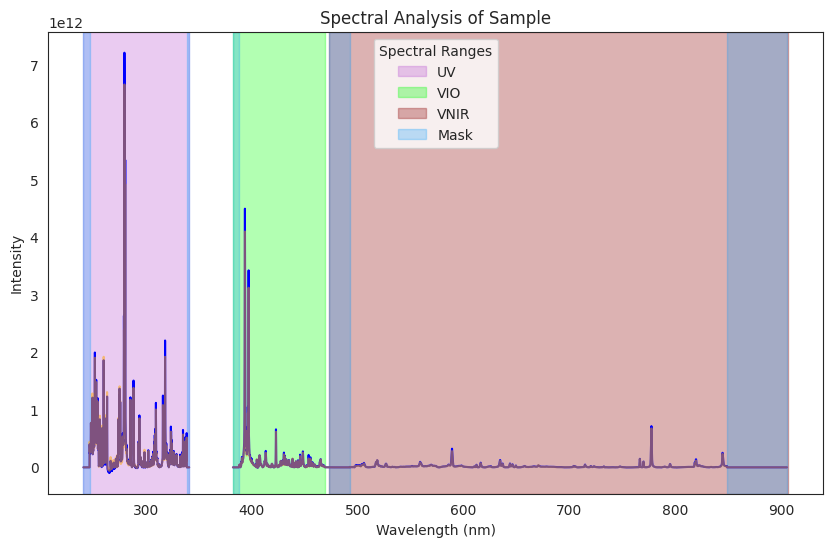

In [46]:
plot_spectra_double(first_location, mean_df)